Content :

1. Visualization
    
    * 1.1 Play audio
    * 1.2 MFCC
    * 1.3 Chroma & Mel
    * 1.4 Feature Extractions

2. Dataset
    
    * 2.1 Audio file (training & testing)
    * 2.2 Deeper into recordings
    * 2.3 Anomaly Detection

3. Construct Model
    
    * 3.1 Convolution Neural Network (CNN)
    * 3.2 LSTM Sequential

4. Model Evaluation
    
    * 4.1 Confussion Matrix CNN Model
    * 4.2 Confussion Matrix LSTM Model
    * 4.3 CNN vs LSTM 

5. Summary

Library used :

In [1]:
import os
import glob
import pandas as pd
import time
import re
import warnings
warnings.filterwarnings("ignore")


# Math
import numpy as np
import random
import librosa
from scipy import signal
from scipy.fftpack import fft
import itertools

# Audio Reader
import soundfile as sf
import IPython.display as ipd

#plotting 
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

from sklearn.decomposition import PCA

# tensor flow & keras
import tensorflow as tf
from tensorflow.contrib import layers
import common
from constants import *
from keras import backend as K
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Adam, Nadam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


# 1. Visualization

We begin with input spectrogram (frequencies), and sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, chroma, and scalled melspectogram


## 1.1 Play Audio

Locate the directory of dataset

In [2]:
# Save file on local directory
path = 'D:/data/spoken-language-identification/spoken-language-identification/train/'
pathtest = 'D:/data/spoken-language-identification/spoken-language-identification/test/'
#path = '.../.../train/'
#pathtest = '.../.../test/'

In [3]:
def getfilnm(path):    
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.flac' in file:
                files.append(os.path.join(r, file))
    #filenm = [x.split('/')[-1] for x in files]
    return(files)

def play(filename):
    # Extract data and sampling rate from file
    data, fs = sf.read(filename, dtype='float32')
    return(ipd.Audio(data, rate = fs))

Choose one of the record from training data

In [4]:
train_name = getfilnm(path)
filename = train_name[10]
data, fs = sf.read(filename, dtype='float32')
play(train_name[10])

In [5]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1000))
    noverlap = int(round(step_size * sample_rate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

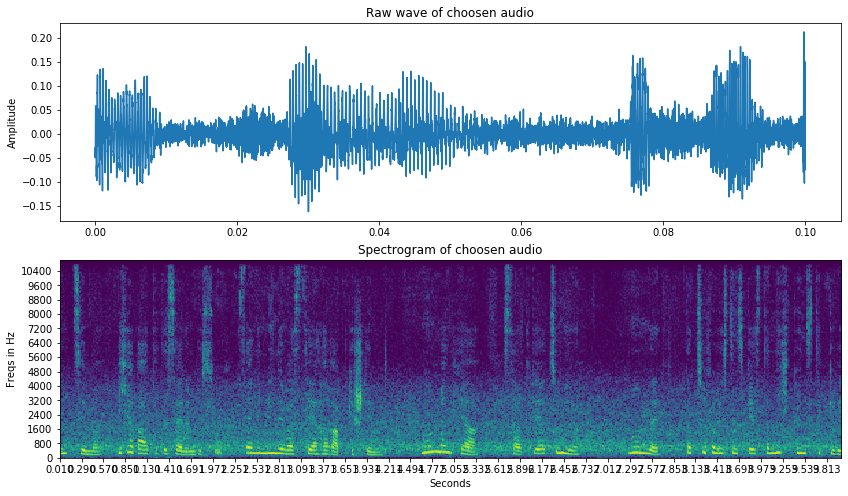

In [6]:
freqs, times, spectrogram = log_specgram(data,fs)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of choosen audio')
ax1.set_ylabel('Amplitude')
ax1.plot(np.array((np.linspace(0, fs/len(data), fs))), data[:fs])

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of choosen audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## 2.3.1

There is some file that has diffrent length sample audio ($lambda$) but, with same sample rate. Its indicating that several audios not really have 10 second duration or 22050 frequency. Thats the first anomaly that i found.
$lambda = frequency * duration$

In [7]:
def uncommon_sample(path):
    exc = []
    train_name = getfilnm(path)
    for name in train_name:
        data, fs = sf.read(name)
        if fs*10 != len(data):
            exc.append(name)
    return(exc)

Lets compare with the 'common' sample audio

In [ ]:
ano1 = uncommon_sample(path)
comm = [x for x in train_name if x not in ano1]

In [ ]:
if len(ano1) > 0:    
    for audio in [ano1[0],comm[0]]:
        data,fs = sf.read(audio)
        freqs, times, spectrogram = log_specgram(data,fs)

        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        if audio == ano1:
            ax1.set_title('Raw wave of uncommon audio')
            ax1.set_ylabel('Amplitude')
            ax1.plot(np.array((np.linspace(0, fs/len(data), fs))), data[:fs])
        else:
            ax1.set_title('Raw wave of fix audio')
            ax1.set_ylabel('Amplitude')
            ax1.plot(np.array((np.linspace(0, fs/len(data), fs))), data[:fs])

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
                   extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        if audio == ano1:
            ax2.set_title('Spectrogram of uncommon audio')
            ax2.set_ylabel('Freqs in Hz')
            ax2.set_xlabel('Seconds')
        else:
            ax2.set_title('Spectrogram of fix audio')
            ax2.set_ylabel('Freqs in Hz')
            ax2.set_xlabel('Seconds')

*This audio will fixed in future extraction process audio step*

In [ ]:
fig = go.Figure(data=[go.Surface(z=spectrogram.T)])
fig.update_layout(title = 'Spectogram Choosen Audio',
                  scene = dict(
                      xaxis_title='Frequencies',
                      yaxis_title='Time',
                      zaxis_title='Log Amplitude'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## 1.2 MFCC
For the detail about MFCC take a look at this link [MFCC Theory](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

In [ ]:
# signal processing
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks

In [ ]:
mfccs = generate_fb_and_mfcc(data,fs)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## 1.3 Chroma & Mel

Other signal processing is chromagram from a waveform or power spectrogram, also mel-scaled spectrogram. and mel from librosa library. For other spectral feature, link as follows : [Spectral Features](http://https://librosa.github.io/librosa/feature.html). But in this study case, i just only feed MFFC to the model

In [ ]:
def chroma(filename):
    data, fs = sf.read(filename, dtype='float32')
    stft = np.abs(librosa.stft(data))
    chroma = librosa.feature.chroma_stft(S=stft, sr=fs)
    return(chroma)
    

def mel(filename):
    data, fs = sf.read(filename, dtype='float32')
    mel = librosa.feature.melspectrogram(data, sr=fs, n_mels=128)
    log_S = librosa.power_to_db(mel, ref=np.max)
    return(log_S)

In [ ]:
logS = mel(filename)

plt.figure(figsize=(12, 4))
librosa.display.specshow(logS, x_axis='time', y_axis='mel')
plt.title('Mel Scalled Spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [ ]:
c = chroma(filename)

plt.figure(figsize=(12, 4))
librosa.display.specshow(c, x_axis='time', y_axis='chroma')
plt.title('Chromagram Spectral')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## 1.4 Feature extractions

We have three features, MFCC, mel, and chroma. In end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. 

In [ ]:
def process_audio(inputdir):
    features = []
    files = random.sample([x for x in getfilnm(inputdir)],500)
    #files = [x for x in getfilnm(inputdir)]
    for file in files:
        filenm = file.split('/')[-1]
        signal, sample_rate = sf.read(file)
        assert len(signal) > 0
        assert sample_rate == 22050
        
        if len(signal) != fs*10:
            signal = signal[:fs*10] ## fix signal if signal != 220500

        fb = generate_fb_and_mfcc(signal, sample_rate)
        cr = chroma(file)
        ml = mel(file)
        
        features.append([filenm,fb,cr,ml])
        
    df_feature = pd.DataFrame(features, columns = ['filenm','filterbanks','chroma','mel'])
    return df_feature

The assert command is to guarantee all data have the same value of sample rate, and none of them are empty audio ($signal > 0$)

In [ ]:
futured = process_audio(path)
futured.head()

# 2. Dataset

The dataset contains speech samples of English, German and Spanish languages. Samples are equally balanced between languages, genders and speakers.
The core of the train set is based on 420 minutes (2520 samples) of original recordings. After applying several audio transformations (pitch, speed and noise) the train set was extended to 12180 minutes (73080 samples). The test set contains 90 minutes (540 samples) of original recordings. No data augmentation has been applied.
I create dataframe function to simplify the data exploration section.

The dataset is divided into 2 directories:

* train (73080 samples)
* test (540 samples)

The filename of the sample has following syntax:

First, i create the data frame that already extract all the informations from each file name

In [ ]:
# create dataframe 
def createdf(pathdir):
    
    df_train = pd.DataFrame({'fullnm' : getfilnm(path)})
    
    #initiate column name
    colnm = []
    df_train['filenm'] = [x.split('/')[-1] for x in df_train['fullnm']]
    if len(df_train['filenm'].str.split(r'[ \_.]', expand=True).loc[0])==5:
        colnm = ['lang','gender','recID','fragID','filetyp']
    elif len(df_train['filenm'].str.split(r'[ \_.]', expand=True).loc[0])==6:
        colnm = ['lang','gender','recID','fragID','sdtyp','filetyp']
    df_train[colnm] = df_train['filenm'].str.split(r'[ \_.]', expand=True)
    
    #drop filetype, filenm
    df_train['sdtyp'] = np.where(df_train['sdtyp']=='flac','',df_train['sdtyp'])
    df_train['sdtyp'] = np.where(df_train['sdtyp']=='','',df_train['sdtyp'].str[:5])
    df_train_usd = df_train.drop(['recID','fragID','filetyp'], axis = 1)
    
    #extracting features
    future = process_audio(pathdir)
    df_train_usd = pd.merge(future,df_train_usd, on = ['filenm'], how = 'left')
    return df_train_usd

In [ ]:
train = createdf(path)
#test = createdf(pathtest)

#class name 0 for en, 1 for de, 2 for es
train['classnm'] = np.where(train['lang']=='en',0,np.where(train['lang']=='de',1,2))
#test['classnm'] = np.where(test['lang']=='en',0,np.where(test['lang']=='de',1,2))

In [ ]:
train.head()

In [ ]:
#test.head()

# 2.1 Number of Records

In [ ]:
print('Number of records ' + str(len(train_name)))

In [ ]:
records = train.groupby(['lang','gender'])['filenm'].count().reset_index()

In [ ]:
import plotly.express as px
data = px.data.gapminder()
fig = px.bar(records, x='lang', y='filenm',
             hover_data=['gender'], color='gender',
             labels={'lang':'Languanges','filenm':'Number of Records'}, height=400)
fig.show()

## 2.2 Deeper into recordings

It is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets. Importants to exclude the duplicates one to prevent overfitting model

In [ ]:
## uncomment for check if there is a duplicate sound
#def get_duplicates(pathdir): 
#    train_name = getfilnm(pathdir)
#    duplicates = []
#    for i in range(len(train_name)-1):
#        a = sf.read(pathdir + train_name[i], dtype='float32')
#        b = sf.read(pathdir + train_name[i+1], dtype='float32')
#        if len([x for x in a if a in b])==len(b):
#            duplicates.append(train_name[i])
#    return duplicates
#dups_train = get_duplicates(path)
#dups_test = get_duplicates(pathtest)

#train = train[~train['fullnm'].isin(dups_train)]
#test = test[~test['fullnm'].isin(dups_test)]

## 2.3 Anomaly Detection

Checking any recordings that somehow stand out from the rest. Lower the dimensionality of the dataset and interactively check for any anomaly. Using PCA for dimensionality reduction:

In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [ ]:
fft_all = []
names = []
#flac = random.sample(comm,100)
flac = comm
for fl in flac:
    samples, sample_rate = sf.read(fl, dtype='float32')
    if samples.shape[0] != sample_rate:
        samples = np.append(samples, np.zeros((samples.shape[0] - sample_rate )))
    x, val = custom_fft(samples, sample_rate)
    fft_all.append(val)
    names.append(fl.split('/')[-1])
    
# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

# 3. Construct Model

In this case, I try two deeplearning models for spoken languange recognitions. There is Convlution Neural Network & Long Short Term Memory (LSTM).


## 3.1 Convolution Neural Network (CNN)

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
SEED = 123
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.set_random_seed(SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

def build_model_cnn(input_shape):
    model = Sequential()
    LANGUANGES = ['ed','se','en']

    # 40x1000

    model.add(Conv2D(
        16,
        (3, 3),
        strides=(1, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=input_shape))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # 20x500

    model.add(Conv2D(
        32,
        (3, 3),
        strides=(1, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # 10x250

    model.add(Conv2D(
        64,
        (3, 3),
        strides=(1, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # 5x125

    model.add(Conv2D(
        128,
        (3, 5),
        strides=(1, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 5), strides=(1, 5), padding='same'))

    # 5x25

    model.add(Conv2D(
        256,
        (3, 5),
        strides=(1, 1),
        padding='same',
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 5), strides=(1, 5), padding='same'))
    model.add(AveragePooling2D(
        pool_size=(5, 5),
        strides=(5, 5),
        padding='valid'))

    # 1x1

    model.add(Flatten())

    model.add(Dense(
        32,
        activation='elu',
        kernel_regularizer=regularizers.l2(0.001)))

    model.add(Dropout(0.5))

    model.add(Dense(len(LANGUANGES)))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])

    return model

In [ ]:
input_shape = (40,1000,1)

# Convert features and corresponding classification labels into numpy arrays
X = np.array(train.filterbanks.tolist())
y = np.array(train.classnm.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
num_rows = input_shape[0]
num_columns = input_shape[1]
num_channels = input_shape[2]

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

In [ ]:
model = build_model_cnn(input_shape)

checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='min')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto')

model.fit(
    x_train,
    y_train,
    epochs=20,
    callbacks=[earlystop],
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=8)

model = load_model('model.h5')
scores = model.evaluate(x_test, y_test, verbose=0)
accuracy = scores[1]
yhat = model.predict(x_test, verbose=0)

print('Accuracy:', accuracy)

# 3.1 Long Short Term Memory Model (LSTM)

In [ ]:
from keras.models import load_model, Sequential, Model
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import Adam, Nadam
import time
import pandas as pd
import os
import numpy as np
from shutil import copyfile
from sklearn import preprocessing

# -------------- Model Begin -----------

def build_model_lstm(input_shape):
    model = Sequential()
    LANGUANGES = ['ed','se','en']

    # 40x1000

    model.add(LSTM(
        16,
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    # 20x500

    model.add(LSTM(
        32,
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    # 10x250

    model.add(LSTM(
        64,
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    # 5x125

    model.add(LSTM(
        128,
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    # 5x25

    model.add(LSTM(
        256,
        kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('elu'))
    # 1x1

    model.add(Flatten())

    model.add(Dense(
        32,
        activation='elu',
        kernel_regularizer=regularizers.l2(0.001)))

    model.add(Dropout(0.5))

    model.add(Dense(len(LANGUANGES)))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    return model

In [ ]:
input_shape = (40,1000,1)

In [ ]:
model1 = build_model_lstm(input_shape)

checkpoint = ModelCheckpoint(
                'modelLSTM.h5',
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                mode='min')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto')

model1.fit(
    x_train,
    y_train,
    epochs=20,
    callbacks=[checkpoint,earlystop],
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=10)

model1 = load_model('modelLSTM.h5')
scores = model1.evaluate(x_test, y_test, verbose=0)
accuracy = scores[1]
yhatLSTM = model1.predict(x_test, verbose=0)

print('Accuracy:', accuracy)

In [ ]:
def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-100, -250), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='left')    

    # Plot
    plt.tight_layout()

In [ ]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), yhat.argmax(axis=1),labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(14, 9))
pretty_print_conf_matrix(y_test.argmax(axis=1),yhat.argmax(axis=1), classes=['english', 'deutsch', 'spain'],
                      title='Confusion matrix, without normalization')